In [1]:
#usual imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import plotnine as gg
from plotnine.data import mtcars

In [2]:
from Subject import Subject
#import charly data
subjs = [Subject("data/subj" + str(n) + ".json") for n in range(201, 207)]

In [3]:
subjs[0].blocks['learning'][0].trial_type

'learning'

In [4]:
STARS_PER_BLOCK = 25 #just put this here so it's parameterized

#makes the star unlock data frame to pass into gg plot
star_cols = ["subject id", "phase", "block number", "trial number", "goal star", "unlocked star", "sucess"]
star_df = pd.DataFrame(columns = star_cols)

#for each suject, appends all the rows
for subj in range(6):
    #skips an outlier
    if subj == 4: continue
    for phase in ["learning", "pos_transfer", "learning2", "neg_trans"]:
        #counts the number of times each of the 6 stars have been seen before within the phase
        pres_numbers = [0] * 6
        #gets the associated list of trials
        trials = subjs[subj].blocks[phase]
        #works out how many blocks are in this phase
        num_blocks = len(trials) // STARS_PER_BLOCK #since 25 stars per block
        for block in range(num_blocks):
            for trial in range(1, STARS_PER_BLOCK+1):
                #makes a dictionary that will be a row in our dataframe
                row = dict()
                row["subject id"] = subj + 201 #start counting subjects for 2.1 at 201
                row["phase"] = phase
                row["block number"] = block
                row["trial number"] = int(trial)
                trial_index = block*STARS_PER_BLOCK + trial - 1
                row["goal star"] = trials[trial_index].goal_star
                row["unlocked star"] = trials[trial_index].unlocked
                row["sucess"] = 1 if row["goal star"] == row["unlocked star"] else 0
                #append row to dataframe
                #if trial == 1:
                if True:
                    #use to have condition since just wanted to count blocks seen, but that's not useful on its own
                    pres_numbers[row["goal star"] - 1] += 1
                row["presentation number"] = int(pres_numbers[row["goal star"] - 1])
                star_df = star_df.append(row, ignore_index = True)

In [5]:
star_df.head()

,subject id,phase,block number,trial number,goal star,unlocked star,sucess,presentation number
0,201,learning,0,1,2,-1,0,1.0
1,201,learning,0,2,2,-1,0,2.0
2,201,learning,0,3,2,-1,0,3.0
3,201,learning,0,4,2,-1,0,4.0
4,201,learning,0,5,2,-1,0,5.0


In [6]:
#adds running performance features to the star_df to plot learning curves
star_df_more = star_df.copy()

star_df_more["phase number"] = star_df["block number"] * 25 +  star_df["trial number"]

def rolling_mean(x, window = 25):
    """given a binary list x, returns a list of the same length with the rolling mean"""
    x = list(x) #because pandas is actually fucking dumb
    res = []
    tot = []
    for i in range(len(x)):
        tot.append(x[i])
        if len(tot) > window:
            tot.pop(0)
        res.append(sum(tot) / len(tot))
    return res

def avg(x):
    return sum(x) / len(x)

learning_curve_df = star_df_more.groupby(["phase", "phase number"]).agg(avg).reset_index()
learning_curves = learning_curve_df.groupby("phase")["sucess"].apply(rolling_mean)
learning_curve_df["learning curve"] = learning_curves[0] + learning_curves[1] + learning_curves[2] + learning_curves[3]

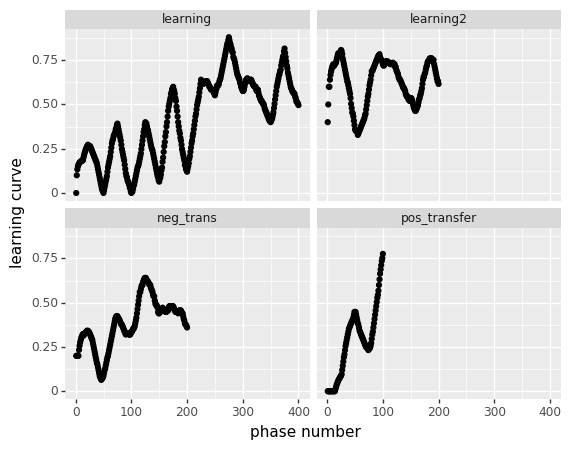

<ggplot: (7548106869)>

In [7]:
#plots the learning curves
(gg.ggplot(learning_curve_df, gg.aes(x='phase number', y='learning curve'))
 + gg.geom_point()
# + gg.stat_summary(geom='bar')
# + gg.stat_smooth(method='lm')
 + gg.facet_wrap('~phase')
)

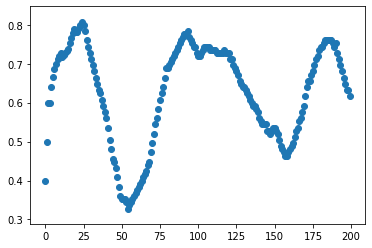

In [8]:
arr = learning_curve_df[learning_curve_df["phase"] == "learning2"]["learning curve"]
plt.scatter(range(len(arr)),arr)

In [9]:
learning_curve_df

,phase,phase number,subject id,block number,trial number,goal star,unlocked star,sucess,presentation number,learning curve
0,learning,1,203.2,0.0,1.0,2.0,-1.0,0.0,1.0,0.000000
1,learning,2,203.2,0.0,2.0,2.0,-0.4,0.2,2.0,0.100000
2,learning,3,203.2,0.0,3.0,2.0,-0.4,0.2,3.0,0.133333
3,learning,4,203.2,0.0,4.0,2.0,-0.4,0.2,4.0,0.150000
4,learning,5,203.2,0.0,5.0,2.0,-0.4,0.2,5.0,0.160000
...,...,...,...,...,...,...,...,...,...,...
895,pos_transfer,96,203.2,3.0,21.0,6.0,6.0,1.0,46.0,0.688000
896,pos_transfer,97,203.2,3.0,22.0,6.0,6.0,1.0,47.0,0.712000
897,pos_transfer,98,203.2,3.0,23.0,6.0,6.0,1.0,48.0,0.736000
898,pos_transfer,99,203.2,3.0,24.0,6.0,4.6,0.8,49.0,0.752000


### A different approach to learning curves

Will average stars over the time they were presented, rather than considering the entire block. Should capture much more of the structure in the task. When I say presentation number, I mean the # times star seen * 25 + trial in block.

In [10]:
learning_curve_df = star_df.groupby(["phase", "presentation number"]).agg(avg).reset_index()
learning_curves = learning_curve_df.groupby("phase")["sucess"].apply(lambda x: rolling_mean(x, 1))
learning_curve_df["learning curve"] = learning_curves[0] + learning_curves[1] + learning_curves[2] + learning_curves[3]

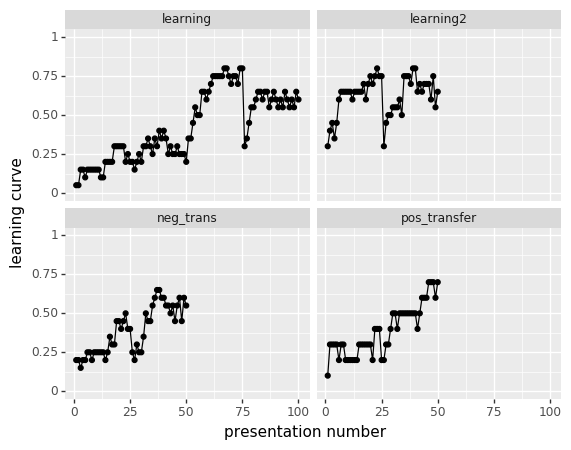

<ggplot: (7546818309)>

In [11]:
#plots the learning curves
(gg.ggplot(learning_curve_df, gg.aes(x='presentation number', y='learning curve'))
 + gg.geom_point()
 + gg.stat_summary(geom='line')
# + gg.stat_smooth(method='lm')
 + gg.coord_cartesian(ylim=(0, 1))
 + gg.facet_wrap('~phase')
)

In [12]:
star_df

,subject id,phase,block number,trial number,goal star,unlocked star,sucess,presentation number
0,201,learning,0,1,2,-1,0,1.0
1,201,learning,0,2,2,-1,0,2.0
2,201,learning,0,3,2,-1,0,3.0
3,201,learning,0,4,2,-1,0,4.0
4,201,learning,0,5,2,-1,0,5.0
...,...,...,...,...,...,...,...,...
4495,206,neg_trans,7,21,2,2,1,46.0
4496,206,neg_trans,7,22,2,2,1,47.0
4497,206,neg_trans,7,23,2,2,1,48.0
4498,206,neg_trans,7,24,2,2,1,49.0
